In [ ]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import functions.nominal_rigidity_network as nominal_rigidity_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 3: Multiple Major Occupations

We now allow for a more flexible occupation-sector structure, using occupation-by-sector employment data from [NEED TO FILL IN].  

In [ ]:
A_spec = 1
data_dir = '../data/clean/'
dfTau    = pd.read_csv(data_dir + 'tau_2021.csv').sort_values(by=['short_names'])
dfepsN   = pd.read_csv(data_dir + 'epsN_2021.csv', index_col=0).sort_index(axis=1)
dfcurlyL = pd.read_csv(data_dir + 'curlyL_2021.csv', index_col=0).sort_index()
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors  = dfA['short_names']
dfDemand = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'short_names'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')
sector_names = list(dfA['short_names']) + ['Agg Y']
occupation_names = list(dfcurlyL.index)
dfepsN_weights = dfepsN.rename_axis('short_names').reset_index().melt(id_vars='short_names')

In [ ]:
dfOccuTau = pd.merge(dfTau, dfepsN_weights, on=['short_names']) 
dfOccuTau.loc[:, "OccuTau"] = dfOccuTau['value'] * dfOccuTau['Tau']
dfOccuTau = dfOccuTau.groupby('variable').aggregate({'OccuTau': 'sum'})
dfOccuTau.head()

In [ ]:
dfOccuMatching_params = pd.merge(dfMatching_params, dfepsN_weights, on=['short_names'])
dfOccuMatching_params.loc[:, "OccuPhi"] = dfOccuMatching_params['value'] * dfOccuMatching_params['matching_efficiency']
dfOccuMatching_params.loc[:, "OccuEta"] = dfOccuMatching_params['value'] * dfOccuMatching_params['unemployment_elasticity']
dfOccuMatching_params = dfOccuMatching_params.groupby('variable').aggregate({'OccuPhi': 'sum', 'OccuEta': 'sum'})
dfOccuMatching_params.head()

In [ ]:
dfOccu = pd.merge(dfLabor_market_yearly, dfepsN_weights, on=['short_names'])
dfOccu.loc[:, "OccuU"] = dfOccu['value'] * dfOccu['Unemployment']
dfOccu.loc[:, "OccuV"] = dfOccu['value'] * dfOccu['Vacancy']
dfOccu.loc[:, "OccuH"] = dfOccu['value'] * dfOccu['Hires']
dfOccu = dfOccu.groupby('variable').aggregate({'OccuU': 'sum', 'OccuV': 'sum', 'OccuH': 'sum'})
dfOccu.loc[:, 'OccuT'] = dfOccu['OccuV'] / dfOccu['OccuU']
dfOccu.head()

In [ ]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J).reshape(J, J)))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
curlyL = np.array(dfcurlyL)

O = dfcurlyL.shape[0]

epsN = np.array((np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64') * dfepsN.T).T)
epsN = np.multiply(epsN, rescaler.T)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])
K = epsK.shape[1]


#if you want to turn of network linkages turn on these two lines of code.
#Omega = np.zeros_like(Omega)
#Psi = np.eye(Omega.shape[0])
θ = dfOccu['OccuT']
ν = dfOccuMatching_params['OccuEta']
U = np.array(dfOccu['OccuU']).reshape((O,1))
V = np.array(dfOccu['OccuV']).reshape((O,1))

#r = 0.0293
tau = dfOccuTau['OccuTau']
curlyT = np.diag(tau)
curlyQ = np.diag(-ν)
curlyF =  np.eye(O) + curlyQ
#curlyT = np.diag(r / (np.mean(φ)*np.mean(θ)**(-ν) - r))
# NOTE: here I am picking the r so the τ's roughly look right. Down the line, we can calibrate τ directly from the data. 
# Also note that tightness is computed from unemployed workers, but in our model it should be computed from the whole work force.

In [ ]:
dlog_lam = np.zeros((J,1))
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)

In [ ]:
# Setting which sectors to shock, and getting the full name of the sector. 
sec_to_shock = 'dur'
shock_size = 0.01
shock_ind = sectors[sectors=='dur'].index.values[0]
# For reference, these are other sectors we can shock
print(sectors)
sec_dict = pd.read_excel("../data/update_raw/long_short_names_crosswalk.xlsx")
sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
print(f'the full name for {sec_to_shock} is {sec_full}')

In [ ]:
WageAssumption = ['Hulten', '0.5MP', 'Rigid Real', 'Rigid Nominal', 'Dampening']


In [ ]:
curlyL[15,:]

## Responses to technology shocks

In [ ]:
# Setting which sectors to shock, and getting the full name of the sector. 
sec_to_shock = 'dur'
shock_size = 0.01
shock_ind = sectors[sectors=='dur'].index.values[0]
# For reference, these are other sectors we can shock
print(sectors)
sec_dict = pd.read_excel("../data/update_raw/long_short_names_crosswalk.xlsx")
sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
print(f'the full name for {sec_to_shock} is {sec_full}')

sectorY_vec = np.zeros((J+1, len(WageAssumption)))
occT_vec = np.zeros((O+1, len(WageAssumption)))
occU_vec = np.zeros((O+1, len(WageAssumption)))
dlog_A = np.zeros((J,1))
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K,1))

dlog_A[shock_ind] = shock_size

#1
i = WageAssumption.index('Hulten')
gamma_A = 1
gamma_H = 1
gamma_K = 1
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

#2
i = WageAssumption.index('0.5MP')
gamma = 0.5
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

#3 
i = WageAssumption.index('Rigid Real')
gamma = 0
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

#4
i = WageAssumption.index('Rigid Nominal')
num=0
dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

#5
i = WageAssumption.index('Dampening')
gamma_A = 1.5
gamma_H = 0.5
gamma_K = 1.5
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

In [ ]:
occU_vec[:,2]

In [ ]:
sectorY_vec[2,2]/sectorY_vec[2,0]

In [ ]:
sectorY_vec[-1,:]

In [ ]:
sectorY_vec[-1,2]/sectorY_vec[-1,0]

In [ ]:
# Setting which sectors to shock, and getting the full name of the sector. 
shock_size = 0.01
for shock_ind in range(sectors.shape[0]):
    sec_to_shock = sectors[shock_ind]
    # For reference, these are other sectors we can shock
    sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
    print(f'the full name for {sec_to_shock} is {sec_full}')

    sectorY_vec = np.zeros((J+1, len(WageAssumption)))
    occT_vec = np.zeros((O+1, len(WageAssumption)))
    occU_vec = np.zeros((O+1, len(WageAssumption)))
    dlog_A = np.zeros((J,1))
    dlog_H = np.zeros((O,1))
    dlog_K = np.zeros((K,1))

    dlog_A[shock_ind] = shock_size

    #1
    i = WageAssumption.index('Hulten')
    gamma_A = 1
    gamma_H = 1
    gamma_K = 1
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #2
    i = WageAssumption.index('0.5MP')
    gamma = 0.5
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #3 
    i = WageAssumption.index('Rigid Real')
    gamma = 0
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #4
    i = WageAssumption.index('Rigid Nominal')
    num=0
    dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
    dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #5
    i = WageAssumption.index('Dampening')
    gamma_A = 1.5
    gamma_H = 0.5
    gamma_K = 1.5
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)
    
    #fig1
    sector_names = list(dfA['short_names']) + ['Agg Y']
    title = f'Response to 1% Technology Shock in {sec_full}'
    xlab = ''
    ylab = '$\ d\log y$ (pct.)'
    save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockY_calib3.png'
    labels = WageAssumption
    bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.2, dpi=300)
    
    #fig2
    occupation_names1 =  occupation_names + ['Agg $\\theta$']
    xlab = ''
    ylab = '$d \log \\theta$  (pct.)'
    save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockT_calib3.png'
    labels = WageAssumption
    bar_plot(100*occT_vec, occupation_names1, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.2, dpi=300)

    # fig3
    occupation_names1 = occupation_names + ['Agg U']
    xlab = ''
    ylab = '$d \log U$  (pct.)'
    save_path = f'../output/figures/{sec_to_shock}_A{A_spec}_AshockU_calib3.png'
    labels = WageAssumption
    bar_plot(100*occU_vec, occupation_names1, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.2, dpi=300)



## Responses to labor force shocks

In [ ]:
# Setting which sectors to shock, and getting the full name of the sector. 
shock_size = 0.01
shock_ind = 15
occ_to_shock = occupation_names[shock_ind]

sectorY_vec = np.zeros((J+1, len(WageAssumption)))
occT_vec = np.zeros((O+1, len(WageAssumption)))
occU_vec = np.zeros((O+1, len(WageAssumption)))
secT_vec = np.zeros((J,len(WageAssumption)))
dlog_A = np.zeros((J,1))
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K,1))

dlog_H[shock_ind] = shock_size

#1
i = WageAssumption.index('Hulten')
gamma_A = 1
gamma_H = 1
gamma_K = 1
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)
dlog_theta_sec = np.sum(np.multiply(dlog_theta, curlyL), axis=0)
secT_vec[:, i] = dlog_theta_sec.flatten()

#2
i = WageAssumption.index('0.5MP')
gamma = 0.5
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)
dlog_theta_sec = np.sum(np.multiply(dlog_theta, curlyL), axis=0)
secT_vec[:, i] = dlog_theta_sec.flatten()

#3 
i = WageAssumption.index('Rigid Real')
gamma = 0
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)
dlog_theta_sec = np.sum(np.multiply(dlog_theta, curlyL), axis=0)
secT_vec[:, i] = dlog_theta_sec.flatten()

#4
i = WageAssumption.index('Rigid Nominal')
num=0
dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)
dlog_theta_sec = np.sum(np.multiply(dlog_theta, curlyL), axis=0)
secT_vec[:, i] = dlog_theta_sec.flatten()

#5
i = WageAssumption.index('Dampening')
gamma_A = 1.5
gamma_H = 0.5
gamma_K = 1.5
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
occT_vec[:-1, i] = dlog_theta.flatten()
dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
sectorY_vec[:-1, i] = dlog_y.flatten()
sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
occU_vec[:-1,i] = dlog_U.flatten()
occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)
dlog_theta_sec = np.sum(np.multiply(dlog_theta, curlyL), axis=0)
secT_vec[:, i] = dlog_theta_sec.flatten()
    



In [ ]:
sectors

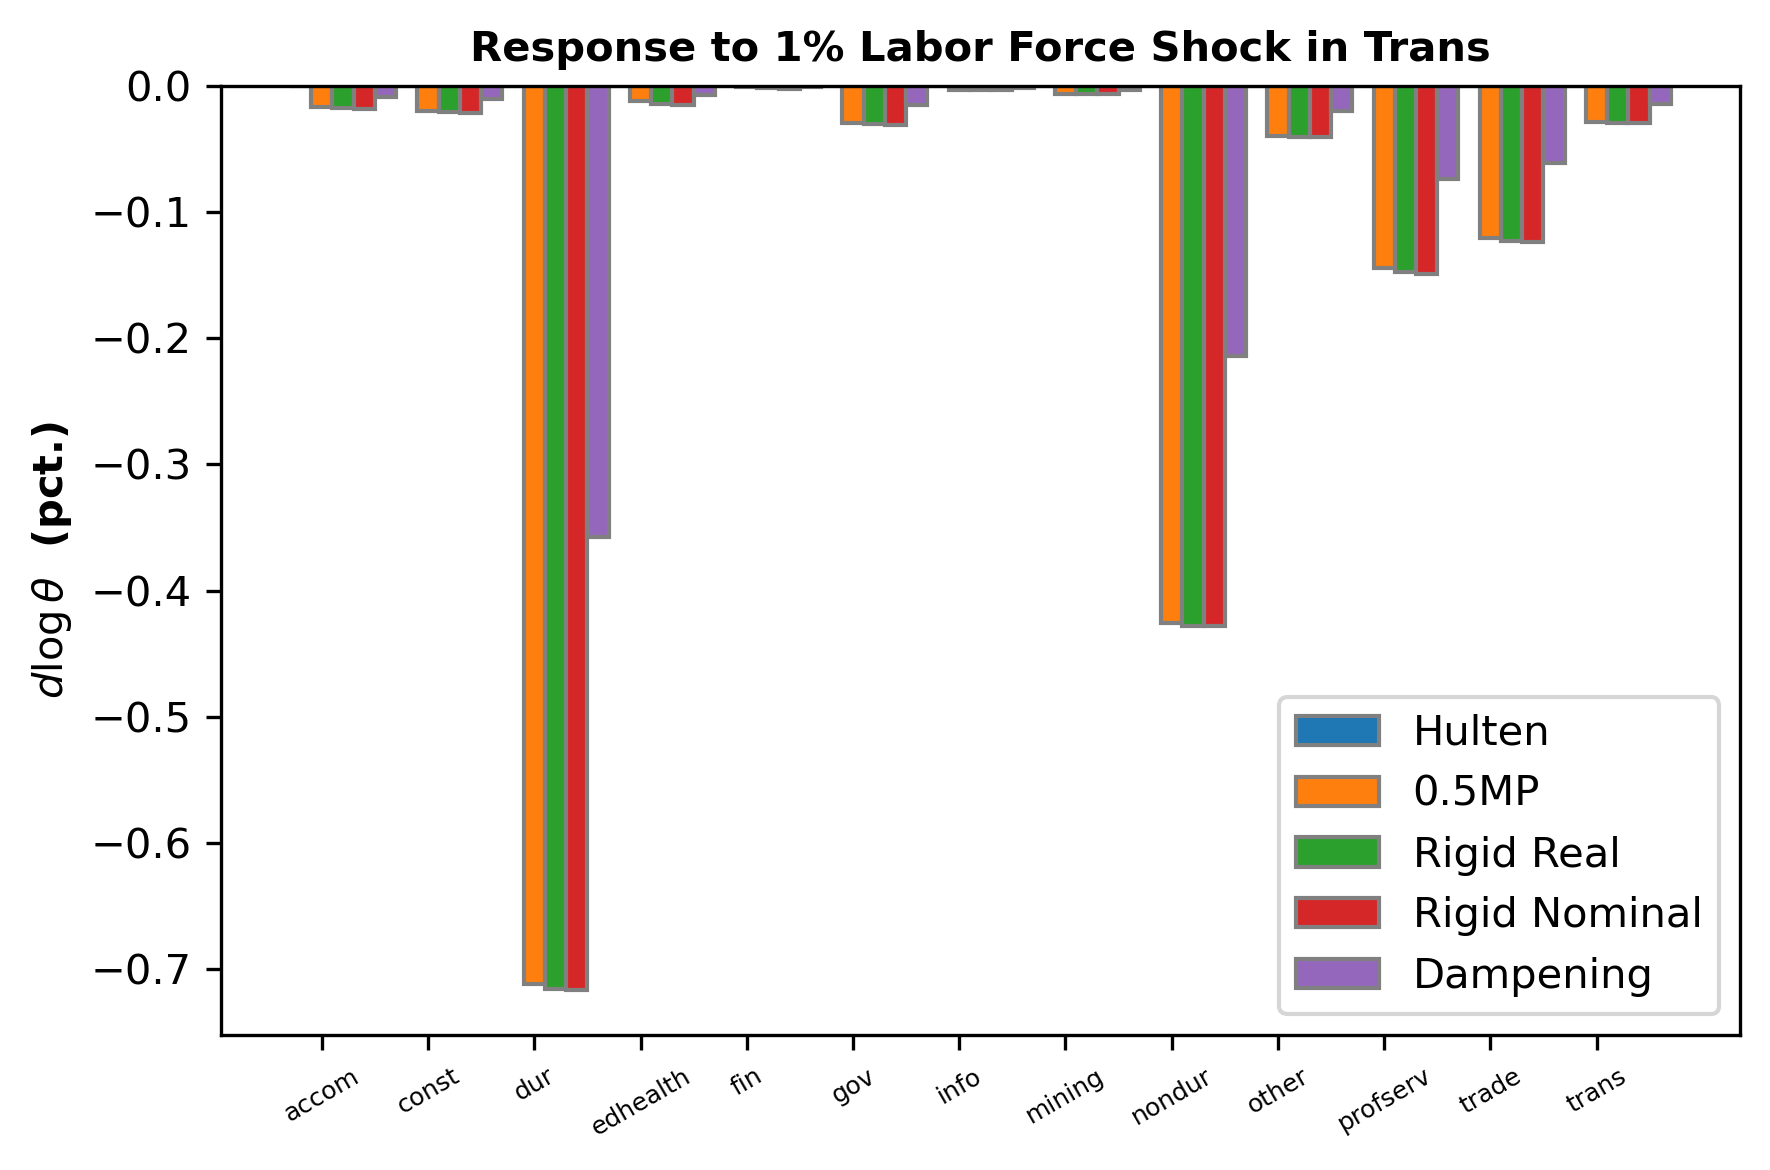

In [46]:
sector_names = list(sectors)
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/prod_A{A_spec}_HshockTsec_calib3.png'
labels = WageAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.2, dpi=300)

In [ ]:
# Setting which sectors to shock, and getting the full name of the sector. 
shock_size = 0.01
for shock_ind in range(len(occupation_names)):
    occ_to_shock = occupation_names[shock_ind]

    sectorY_vec = np.zeros((J+1, len(WageAssumption)))
    occT_vec = np.zeros((O+1, len(WageAssumption)))
    occU_vec = np.zeros((O+1, len(WageAssumption)))
    dlog_A = np.zeros((J,1))
    dlog_H = np.zeros((O,1))
    dlog_K = np.zeros((K,1))

    dlog_H[shock_ind] = shock_size

    #1
    i = WageAssumption.index('Hulten')
    gamma_A = 1
    gamma_H = 1
    gamma_K = 1
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #2
    i = WageAssumption.index('0.5MP')
    gamma = 0.5
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #3 
    i = WageAssumption.index('Rigid Real')
    gamma = 0
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #4
    i = WageAssumption.index('Rigid Nominal')
    num=0
    dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
    dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)

    #5
    i = WageAssumption.index('Dampening')
    gamma_A = 1.5
    gamma_H = 0.5
    gamma_K = 1.5
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, gamma_K, Psi, curlyL, epsN, epsK)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:-1, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A, dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    dlog_U = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H)
    occU_vec[:-1,i] = dlog_U.flatten()
    occU_vec[-1, i] = multi_occupation_network.AggUnemploymentFunc(dlog_U, U)
    occT_vec[-1, i] = multi_occupation_network.AggThetaFunc(dlog_theta, dlog_U, U, V)
    
    #fig1
    sector_names = list(dfA['short_names']) + ['Agg Y']
    title = f'Response to 1% Labor Force Shock in {occ_to_shock}'
    xlab = ''
    ylab = '$d \log y$ (pct.)'
    save_path = f'../output/figures/{occ_to_shock}_A{A_spec}_HshockY_calib3.png'
    labels = WageAssumption
    bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.2, dpi=300)
    
    #fig2
    occupation_names1 =  occupation_names + ['Agg $\\theta$']
    xlab = ''
    ylab = '$d \log \\theta$  (pct.)'
    save_path = f'../output/figures/{occ_to_shock}_A{A_spec}_HshockT_calib3.png'
    labels = WageAssumption
    bar_plot(100*occT_vec, occupation_names1, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.2, dpi=300)

    # fig3
    occupation_names1 = occupation_names + ['Agg U']
    xlab = ''
    ylab = '$d \log U$  (pct.)'
    save_path = f'../output/figures/{occ_to_shock}_A{A_spec}_HshockU_calib3.png'
    labels = WageAssumption
    bar_plot(100*occU_vec, occupation_names1, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.2, dpi=300)

